# Spectral Bias Analysis using Trace Jacobian of PINN Loss Terms for Cavity Flow



In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import torch
import gc
from matplotlib import pyplot as plt

Import local packages

In [8]:
from src.utils.logger import Logging
from src.utils.color import model_color
from src.utils.plot_spectral import plot_spectral

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.

In [9]:
TEST_CHECKPOINT_PATH = os.path.join("result/cavity")
logger = Logging(TEST_CHECKPOINT_PATH)
result_dir = logger.get_output_dir()

In [ ]:
# tanh

# python -m src.trainer.main_trainer --total_epochs 60000  --save_every 1000 --print_every 1000 --batch_size 128 --log_path ./checkpoints --solver pspline  --problem cavity --weights "[2 , 2 , 2 , 2 , 4 , 0.1]" --network "[3, 100, 100, 100, 3]" --dataset_path ./data/cavity.mat

SyntaxError: invalid syntax (3034279271.py, line 3)

In [11]:
TANH_NORM_DIST = "./checkpoints/2025-05-28_22-38-57-252963/model.pth"
TANH_PARAM_DIST = "./checkpoints/2025-05-28_22-40-10-837580/model.pth"
BSPLINE_DIST = "./checkpoints/2025-05-29_17-17-32-275749/model.pth"  # "./checkpoints/2025-05-28_22-42-53-023014/model.pth"
GRBF_DIST = "./checkpoints/2025-05-28_22-50-18-333877/model.pth"
FOURIER_DIST = "./checkpoints/2025-05-28_22-46-52-834987/model.pth"
CHEBTSHEV_DIST = "./checkpoints/2025-05-28_22-48-44-333958/model.pth"
JACOBI_DIST = "./checkpoints/2025-05-28_22-44-54-420583/model.pth"


MODEL_PATH_LIST = {
    "tanh": TANH_NORM_DIST,
    "param_tanh": TANH_PARAM_DIST,
    "grbf": GRBF_DIST,
    "bspline": BSPLINE_DIST,
    "chebyshev": CHEBTSHEV_DIST,
    "jacobi": JACOBI_DIST,
    "fourier": FOURIER_DIST,
}

## Load the saved models 

In [12]:
trace_jacobian_bc_log_dic = {}
trace_jacobian_res_log_dic = {}
trace_jacobian_ic_log_dic = {}

for model_name, model_path in MODEL_PATH_LIST.items():
    logger.print(f"MODEL_PATH {model_path}")

    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")
    trace_jacobian_bc_log = state.get("trace_jacobian_bc_log")
    trace_jacobian_ic_log = state.get("trace_jacobian_ic_log")
    trace_jacobian_res_log = state.get("trace_jacobian_res_log")

    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_dict = state.get("loss_history")

    logger.print(f"activation:  , {model_activation_name}")
    logger.print(f"problem: {config.get('problem')}")
    logger.print(f"solver:  , {solver}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")

    # logger.print(
    #     f"Model {model_name} with iterations: {len(loss_dict[next(iter(loss_dict))])}"
    # )

    trace_jacobian_bc_log_dic[model_name] = trace_jacobian_bc_log
    trace_jacobian_res_log_dic[model_name] = trace_jacobian_res_log
    trace_jacobian_ic_log_dic[model_name] = trace_jacobian_ic_log

    logger.print("******************************\n")
    gc.collect()
    torch.cuda.empty_cache()

logger.print("file directory:", logger.get_output_dir())

INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-28_22-38-57-252963/model.pth


INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: cavity
INFO:src.utils.logger:solver:  , tanh
INFO:src.utils.logger:network:  , [3, 300, 300, 300, 3]
INFO:src.utils.logger:term loss weights :  , [2.0, 2.0, 2.0, 2.0, 4.0, 0.1]
INFO:src.utils.logger:******************************

INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-28_22-40-10-837580/model.pth
INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: cavity
INFO:src.utils.logger:solver:  , param_tanh
INFO:src.utils.logger:network:  , [3, 50, 50, 50, 3]
INFO:src.utils.logger:term loss weights :  , [2.0, 2.0, 2.0, 2.0, 4.0, 0.1]
INFO:src.utils.logger:******************************

INFO:src.utils.logger:MODEL_PATH ./checkpoints/2025-05-28_22-50-18-333877/model.pth
INFO:src.utils.logger:activation:  , None
INFO:src.utils.logger:problem: cavity
INFO:src.utils.logger:solver:  , grbf
INFO:src.utils.logger:network:  , [3, 50, 50, 50, 3]
INFO:src.utils.logger:term loss weights :  , [2.0,

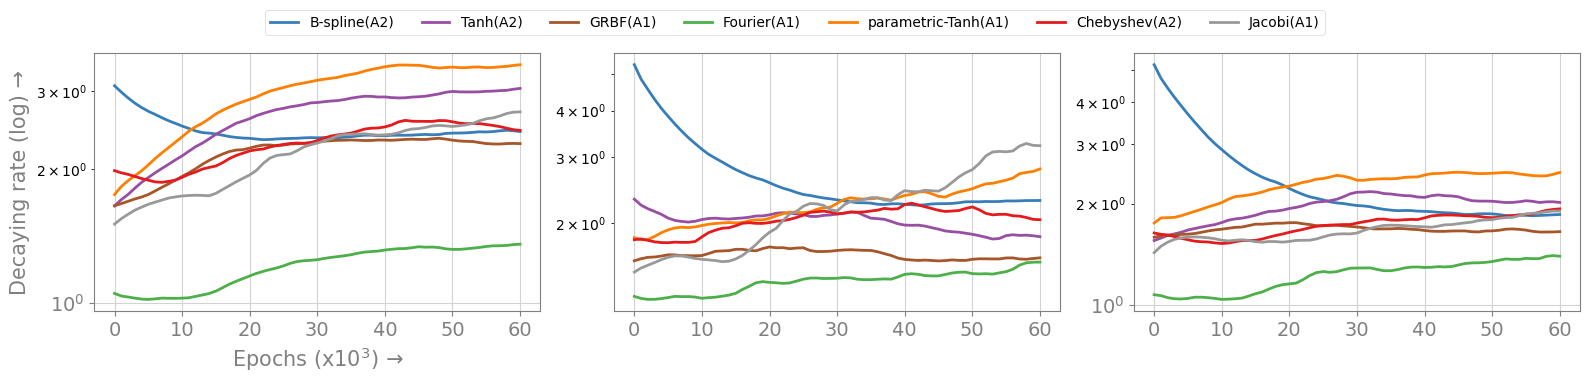

In [13]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches([16, 3.5])
dict_list = [
    trace_jacobian_bc_log_dic,
    trace_jacobian_ic_log_dic,
    trace_jacobian_res_log_dic,
]
lines = []
labels = []

for index in range(len(dict_list)):
    data_list = [
        {
            "data": dict_list[index]["bspline"],
            "color": model_color["bspline"],
            "name": "B-spline(A2)",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["tanh"],
            "color": model_color["tanh"],
            "name": "Tanh(A2)",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["grbf"],
            "color": model_color["grbf"],
            "name": "GRBF(A1)",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["fourier"],
            "color": model_color["fourier"],
            "name": "Fourier(A1)",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["param_tanh"],
            "color": model_color["param_tanh"],
            "name": "parametric-Tanh(A1)",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["chebyshev"],
            "color": model_color["chebyshev"],
            "name": "Chebyshev(A2)",
            "alpha": 1.0,
        },
        {
            "data": dict_list[index]["jacobi"],
            "color": model_color["jacobi"],
            "name": "Jacobi(A1)",
            "alpha": 1.0,
        },
    ]

    plot_spectral(ax[index], data_list, index)


for line in ax[-1].get_lines():
    lines.append(line)
    labels.append(line.get_label())

save_path = os.path.join(logger.get_output_dir(), "trace_jacobian_cavity.png")

legend = fig.legend(
    lines, labels, loc="upper center", bbox_to_anchor=(0.5, 1.1), ncol=7
)
legend.get_frame().set_facecolor("white")

plt.tight_layout()
plt.savefig(save_path)